# An Exploratory Data Analysis of Billboard Hot 100 Singles and Lyrics 

## 1.0 Background, Aims and Objectives
### 1.1 Background
When reading Metro News, I came across an article which was reporting the controversial lyrics used in ‘Grrrls’. A song by Melissa Viviane Jefferson who is also known as Lizzo an American singer, rapper and songwriter. The controversy was over the use of the word ‘spaz’  in her lyrics which is offensive to disabled people. She handled the situation diplomatically by apologizing on Twitter and even changing the lyrics of the song. When discussing this controversy with my friends and family they had mixed opinions a few said people are very sensitive now meanwhile others argued that music has become more negative and derogatory over time. When I searched the internet I discovered there were more artists who faced the same issue like Taylor Swift (‘Picture to Burn’’ for using ‘gay’ in a negative context), Michael Jackson (‘They don’t care about us’ for anti-semitic slurs) and many others. 
I started to wonder whether an exploratory analysis could be done on the changes in lyrics of popular music over time and see if I can find any interesting discoveries or patterns to support the argument. Unfortunately, I will not be analyzing changes in loudness or rythm but it would be an interesting continuation of my analysis. 

### 1.2 Aims and Objectives
In this project, I plan on:
- Analysing changes in words used in lyrics over time
- Analysing changes in affectivity of lyrics over time 
- Variation of song lyrics length over time

To do this I will need to analyse a data set of popular songs and their respective lyrics for each year preferably in Comma Separated Value (CSV) format. 

## Libraries and Packages used for this report
For this analysis I used Pandas, nltk, matplotlib.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
import requests
import warnings
import unidecode
import re
import networkx as nx
import string
import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import webtext
from nltk.probability import FreqDist
from wordcloud import WordCloud
from wordcloud import STOPWORDS


%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 999
warnings.filterwarnings('ignore')

In [41]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 2.0 Data

### 2.1 Data Requirements and Plan
For this analysis, I wanted to find a CSV file with all the lyrics already scraped however unfortunately such a dataset was not available online. So I decided to scrape the data from websites online. Even though this would take more of my time it also gives me more freedom in choosing songs and also the data can always be updated as long as the websites are still active. This means the dataset can easily be updated as time passes by. 
I found Wikipedia publishes the top 100 Singles at the end of each year since 1960. This data can be scraped using Beautiful Soup. This gives me a dataset of the top 100 popular songs of each year. 
I was a bit puzzled about how to scrape song lyrics for each song as I could not find any API at the time. However, when I was researching I discovered a conversation on web scraping lyrics from Azlyrics (www.azlyrics.com) on StackOverflow. However, the snippet of code did not work for many of my songs so I decided to use the same idea but scrape Songlyrics (www.songlyrics.com/).

### 2.2 Webscraping Billboard Hot 100 Singles Lyrics 
To webscrape the top 100 Singles of each year, I used beautiful soup to scrape data from wikipedia pages. 
Wikipedia publishes the Top 100 Singles at the end of each year. I thought this was perfect method to retrieve popular songs of each year. However Wikipedia does not provide this data in a CSV format hence there is no option but to webscrape the data. 

#### 2.2.1 Billboards Top 100 Singles - Web Scraping
All though Wikipedia does provide this data it publishes the data as a single page each year; instead of a table with all the Singles. This complicates the process however I noticed that Wikipedia keeps their base url format each year the same and the format of the table is the same as well. So I decided on using the base url and a for loop which loops through the years generating an array of HTMLs to be webscraped.   

In [42]:
baseUrl = 'https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_{}'

dictHTML = dict()
for bbYear in range(1960, 2022):
    formtdUrl = baseUrl.format(bbYear)
    wikihtml = requests.get(url=formtdUrl).content
    dictHTML[bbYear] = bs4.BeautifulSoup(wikihtml)

dataFrames = list()    

for bbYear, bs in dictHTML.items():
    # Find billboard table from scraped Billboard (BB) HTML pages
    # Store scraped Billboard(BB) data into a variable bbData
    bbData = dictHTML[bbYear]\
        .find('table', {'class':'wikitable sortable'})\
        .find_all('tr')
    # Store table contents into a list bbRows for manipulation
    bbRows = [bbRow.contents for bbRow in bbData]
    # fix tr object with no data
    bbRows = [bbRow[1::2] for bbRow in bbRows][1:]
    
    # Billboard Columns  
    bbSongs = list()
    bbRanks = list()
    bbArtists_all = list() 
    bbArtists_base = list()
    
    for bbRow in bbRows:
        bbRanks.append(str(bbRow[0].contents[0]))
        bbArtists_all.append(' '.join(bbRow[2].findAll(text=True)))

        if len(bbRow[1].contents) == 1:
            bbSongs.append(str(bbRow[1].contents[0]))
        else:
            bbSongs.append(str(bbRow[1].contents[1].findAll(text=True)[0]))
            
        if not isinstance(bbRow[2].contents[0], bs4.NavigableString):
            bbArtists_base.append(bbRow[2].contents[0].get('title'))
        else:
            bbArtists_base.append(str(bbRow[2].contents[0]))
    
    
    bbSongs = [song.strip("\"") for song in bbSongs]
    
    bbData = dict(rank=bbRanks,
                song=bbSongs,
                artist_base=bbArtists_base,
                artist_all=bbArtists_all,
                year=bbYear)
    dataFrame = pd.DataFrame(bbData)
    dataFrames.append(dataFrame)
billboardData = pd.concat(dataFrames, axis=0)
billboardData[['song', 'artist_all', 'artist_base']]\
    = billboardData[['song', 'artist_all', 'artist_base']].applymap(str.lower)
billboardData = billboardData.reset_index()

#### 2.2.2 Billboards Top 100 Singles - Data Cleaning

In [43]:
billboardData['rank'] = billboardData['rank'].replace('Tie', np.nan).astype(float).interpolate()

# Clean Billboard Song Names 
billboardData.at[33, 'song'] = 'night' # HTML errors
billboardData.at[398, 'song'] = 'Green, Green' # HTML errors
billboardData.at[247, 'song'] = 'al di la' # Corrupted Text
billboardData.at[626, 'song'] = 'walk away renee' # Corrupted Text
billboardData.at[673, 'song'] = 'rainy day women 12 35' # url link fix
billboardData.at[2392, 'song'] = 'true' # url link fix
billboardData.at[4590, 'song'] = 'true' # url link fix
billboardData.at[6149, 'song'] = 'telepatia' # url link fix
billboardData.tail(5)

# Clear disambiguations 
billboardData[['artist_base', 'artist_all']]\
    = billboardData[['artist_base', 'artist_all']].applymap(
        lambda x: re.sub(r'\(.*', '', x).strip()
    )

#### 2.2.3 Webscraping Lyrics of Billboard Hot 100 Singles
I have now scraped and stored top 100 Singles of each year, now I have to find matching lyrics for each single. For this I firstly open the billboards CSV so it can be read.

In [44]:
billboardLyricsData = billboardData
billboardLyricsData.tail(5)

,index,rank,song,artist_base,artist_all,year
6196,95,96.0,things a man oughta know,lainey wilson,lainey wilson,2021
6197,96,97.0,throat baby (go baby),brs kash,brs kash,2021
6198,97,98.0,tombstone,rod wave,rod wave,2021
6199,98,99.0,drinkin' beer. talkin' god. amen.,chase rice,chase rice featuring florida georgia line,2021
6200,99,100.0,todo de ti,rauw alejandro,rauw alejandro,2021


In [ ]:
def urlFormatter (input):
    input = input.replace('&', 'and')
    input = input.replace('-', ' ')
    input = input.translate(str.maketrans('', '', string.punctuation))
    input = unidecode.unidecode(input)
    return input

billboardLyricsData[['url_formatted_song']]\
    = billboardLyricsData[['song']].applymap(urlFormatter)

billboardLyricsData[['artist_base']]\
    = billboardLyricsData[['artist_base']].applymap(
        lambda x: x.replace('&', 'and'))

billboardLyricsData[['url_formatted_artist']]\
    = billboardLyricsData[['artist_base']].applymap(urlFormatter)
billboardLyricsData.sample(5)

bbLyrics = list()

for index, row in billboardLyricsData.iterrows():
    frmttdsong = row['url_formatted_song']
    frmttdArtist = row['url_formatted_artist']
    frmttdArtist2 = re.sub(r'^the ', '', row['url_formatted_artist']) 
    
    bbLyricsUrls = list()
    lyricsUrl = 'http://songlyrics.com/{}/{}-lyrics/'.format(
        frmttdArtist.replace(' ', '-'), frmttdsong.replace(' ', '-'))
    bbLyricsUrls.extend([lyricsUrl])
    
    if frmttdArtist != frmttdArtist2:
        lyricsUrl = 'http://songlyrics.com/{}/{}-lyrics/'.format(
            frmttdArtist2.replace(' ', '-'), frmttdsong.replace(' ', '-'))
        bbLyricsUrls.extend([lyricsUrl])
    
    for url in bbLyricsUrls:
        try:
            lyricsHTML = requests.get(url=url).content
            soup = bs4.BeautifulSoup(lyricsHTML)
            lyrics = soup\
                .find('p', {'id': 'songLyricsDiv'})\
                .findAll(text=True)
            if 'Sorry, we have no ' in lyrics[0]:
                    lyrics = None
            break
        except:
            print('Error: Not valid link')
    bbLyrics.append(lyrics)

Error: Not valid link


In [31]:
billboardLyricsData['lyrics'] = bbLyrics
billboardLyricsData['lyrics'].isnull().sum() / len(billboardLyricsData)
print(bbLyrics[0])

["There's a summer place", '\nWhere it may rain or storm', "\nYet I'm safe and warm", '\n', '\nFor within that summer place', '\nYour arms reach out to me', '\nAnd my heart is free from all care for it knows', '\n', '\nThere are no gloomy skies', '\nWhen seen through the eyes', '\nOf those who are blessed with love', '\n', '\nAnd the sweet secret of', '\nA summer place', "\nIs that it's anywhere", '\n', '\nWhen two people share', '\nAll their hopes, all their dreams', '\nAll their love', '\n', "\nThere's a summer place", '\nWhere it may rain or storm', "\nYet I'm safe and warm", '\n', '\nIn your arms, in your arms', '\nIn your arms, in your arms', '\nIn your arms, in your arms']


#### 2.2.4 Billboard Hot 100 Singles Lyrics - Cleaning 

In [32]:
def lyricsCleaner(inputLyrics):
    # Check if empty
    if inputLyrics is None:
        return inputLyrics
    # Combine lyrics into single string
    inputLyrics = ' '.join(inputLyrics)
    # Remove structure tags
    inputLyrics = re.sub(r'[\*\[|\(|\{].*\n*.*[\]\)\}\*]' , ' ', inputLyrics)
    # Change repeating spaces with single space
    inputLyrics = re.sub(r'\s+', ' ', inputLyrics)
    # convert to lowercase
    inputLyrics = inputLyrics.lower()
    # Remove Punctuation
    inputLyrics = inputLyrics.translate(str.maketrans('', '', string.punctuation))
    return inputLyrics

cleanLyrics = list(map(lyricsCleaner, bbLyrics))
print(cleanLyrics[0])
billboardLyricsData['lyrics'] = cleanLyrics

theres a summer place where it may rain or storm yet im safe and warm for within that summer place your arms reach out to me and my heart is free from all care for it knows there are no gloomy skies when seen through the eyes of those who are blessed with love and the sweet secret of a summer place is that its anywhere when two people share all their hopes all their dreams all their love theres a summer place where it may rain or storm yet im safe and warm in your arms in your arms in your arms in your arms in your arms in your arms


In [33]:
billboardLyricsData.to_csv('../csvData/billboardLyricsData.csv', index=None)

## 3.0 Data Analysis of Billboard Hot 100 Singles Lyrics 

### Opening and Reading Billboard and Lyrics CSV
I scraped both billboard top 100s and their respective lyrics and stored it in a CSV file. For analysis I must open the CSV file in a reading format and store the data for analysis.   

In [4]:
myWords = []

data = pd.read_csv('../csvData/billboardLyricsData.csv', encoding='utf-8', keep_default_na=False, skipinitialspace=True)
index = data.index
number_of_rows = len(index)

### 3.1 Ten year interval Word Cloud Analysis
For the analysis of lyrics I can initially start with wordclouads which is quite popular method for analysing the popularity of  words used in lyrics. I can use this to infer the genre and understand what listeners wish to hear. 

#### World Cloud Analysis of Popular Song Lyrics of all time

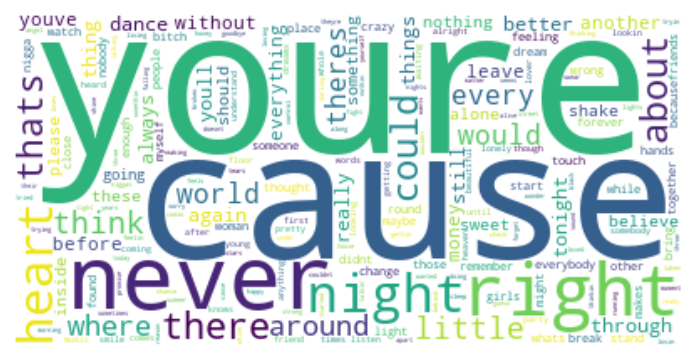

In [35]:
for row in data['lyrics']:
    myWords = myWords + nltk.word_tokenize(row)
data_analysis = nltk.FreqDist(myWords)

filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 4])
wcloud = WordCloud(background_color='white', 
                    collocations=False).generate_from_frequencies(filter_words)
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
(-1.5, 200, 100, -2.5)
plt.show()

The wordcloud worked however I were unable to find anything as most of the frequent words were stop words. We can filter stopwords to get a more meaningful ananalysis.  

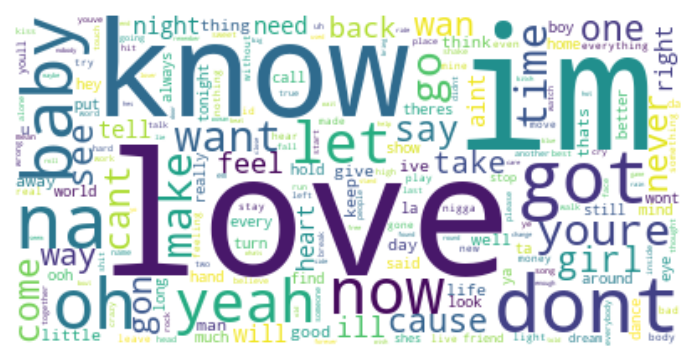

In [36]:
for row in data['lyrics']:
    myWords = myWords + nltk.word_tokenize(row)
stop_words = set(STOPWORDS)    
filtered = [word for word in myWords if not word in stop_words]

filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 4])
wcloud = WordCloud (background_color='white', 
                    collocations=False).generate(' '.join(filtered))
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
(-1.5, 200, 100, -2.5)
plt.show()

After filtering stopwords we can see the most popular word used is 'love' in lyrics throughout the last 50 years. We can still see maany stopwords are still inside the wordcloud even after filtering the default stopwords. We can still see that 'baby' and 'girl' are also very popular words. From this we can understand that in general love songs are the most popular types of songs.

#### 1960 - Word Cloud Analysis

I have additionaly added some more stopwords which have no meaning and can be seen below. These stopwords were not filtered, so I added them manually to get a better and more meaningful visualizations. 

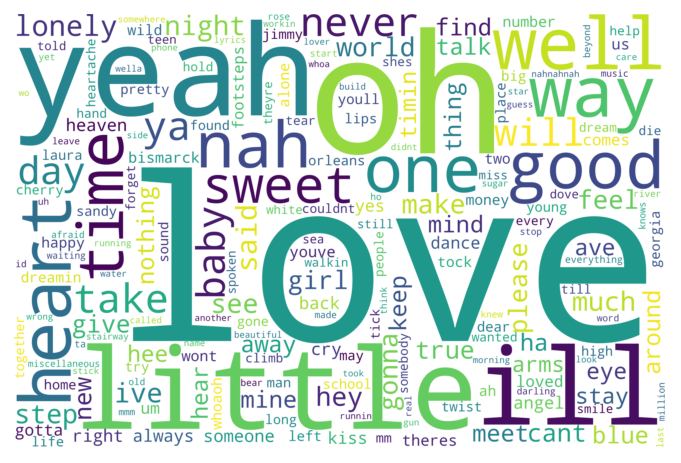

In [51]:
lyrics = ''
for i in range(0, 100):
    lyrics = lyrics + data.at[i, 'lyrics'] + '-'

stop_words = set(STOPWORDS)    
extra_stopwords = ["im", "know", "na", "got", "youre", "dont", "now", "let", "come", "thats", "go", "wanna", "need", "want", "aint",
                  "say", "tell", "cause"]
stop_words.update(extra_stopwords)

word_cloud2 = WordCloud(
        width=6000,
        height=4000,
        background_color='white', 
        collocations=False,
        stopwords=stop_words
    ).generate(lyrics)

plt.imshow(word_cloud2, interpolation="bilinear")
plt.axis("off")
(-1.5, 200, 100, -2.5)
plt.show()

From this visualisation we can see that in the 1960, 'Love' is still the most popular which is followed by 'Heart'. This visualisation tells us Love songs are the most popular topic for music in the 1960s. 

#### 1970 - Word Cloud Analysis

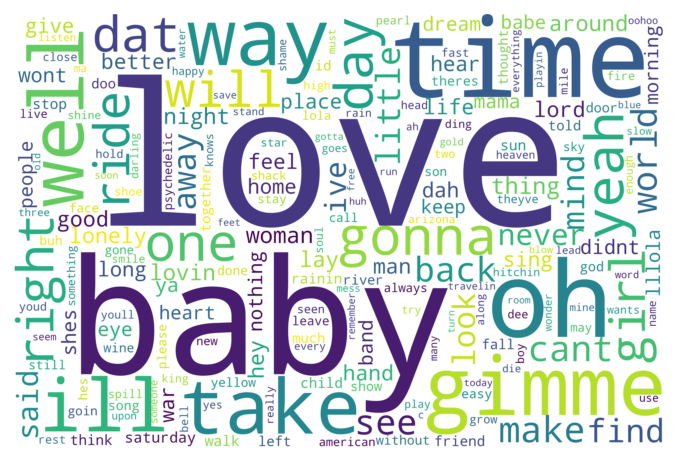

In [50]:
lyrics = ''
for i in range(1000, 1100):
    lyrics = lyrics + data.at[i, 'lyrics'] + ' '

word_cloud3 = WordCloud(
        width=6000,
        height=4000,
        background_color='white', 
        collocations=False,
        stopwords=stop_words
    ).generate(lyrics)

plt.imshow(word_cloud3, interpolation="bilinear")
plt.axis("off")
(-1.5, 200, 100, -2.5)
plt.show()

From the 1970 visualisation we can see that love is still the most popular topic but we can also see a increase in the use of the words 'baby' and 'time' from the 1960s. 

#### 1980 - Word Cloud Analysis

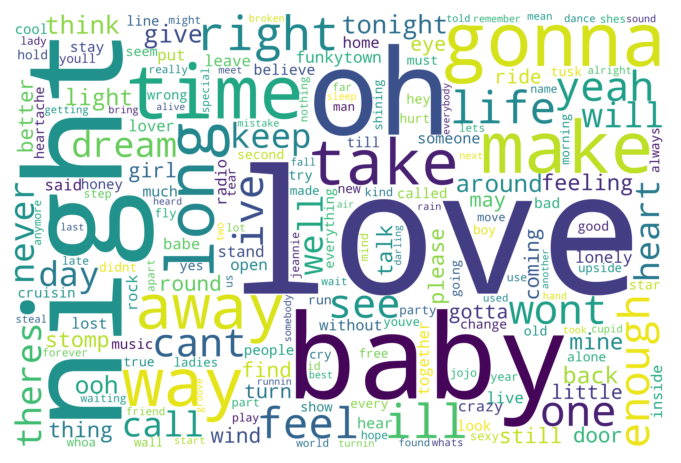

In [49]:
lyrics = ''
for i in range(2000, 2100):
    lyrics = lyrics + data.at[i, 'lyrics'] + ' '
word_cloud4 = WordCloud(
        width=6000,
        height=4000,
        background_color='white', 
        collocations=False,
        stopwords=stop_words
    ).generate(lyrics)

plt.imshow(word_cloud4, interpolation="bilinear")
plt.axis("off")
(-1.5, 200, 100, -2.5)
plt.show()

In the 1980s 'love' remains the most used however the use of the word 'night' has aolso become as popular as love followed by 'baby'. The new found popularity off the word 'night' could signify the change in nightlife. After all the 80's are considered to be the peak of nightlife and the era in which discos became mainstream.

#### 1990 - Word Cloud Analysis

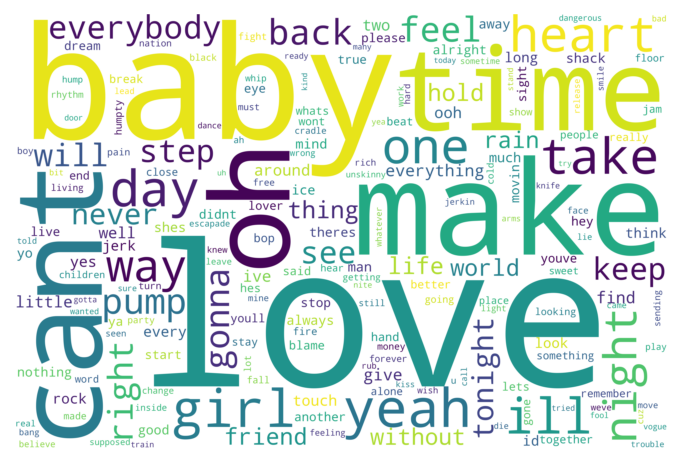

In [55]:
lyrics = ''
for i in range(3000, 3100):
    lyrics = lyrics + data.at[i, 'lyrics'] + ' '

word_cloud5 = WordCloud(
        width=6000,
        height=4000,
        background_color='white', 
        collocations=False,
        stopwords=stop_words
    ).generate(lyrics)

plt.imshow(word_cloud5, interpolation="bilinear")
plt.axis("off")
(-1.5, 200, 100, -2.5)
plt.show()

The 1990s seems to go back to 'Love', 'baby', 'girl' but 'time' also has become popular could mean songs about the past or past events have become popular.

#### 2000 - Word Cloud Analysis

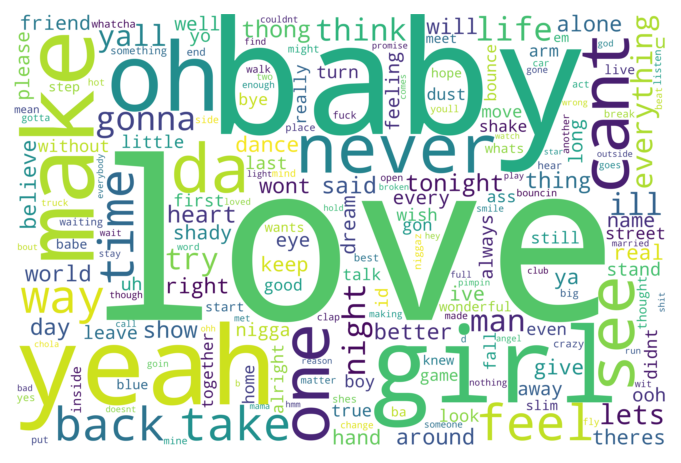

In [56]:
lyrics = ''
for i in range(4000, 4100):
    lyrics = lyrics + data.at[i, 'lyrics'] + ' '
    
word_cloud6 = WordCloud(
        width=6000,
        height=4000,
        background_color='white', 
        collocations=False,
        stopwords=stop_words
    ).generate(lyrics)

plt.imshow(word_cloud6, interpolation="bilinear")
plt.axis("off")
(-1.5, 200, 100, -2.5)
plt.show()

In 2000s there is not much of a change compared to the previous decade except 'time' is no longer popular. 

#### 2010 - Word Cloud Analysis

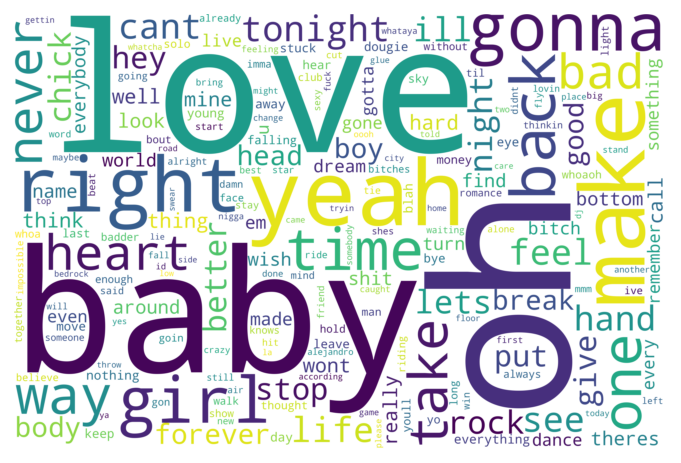

In [57]:
lyrics = ''
for i in range(5000, 5100):
    lyrics = lyrics + data.at[i, 'lyrics'] + ' '

word_cloud7 = WordCloud(
        width=6000,
        height=4000,
        background_color='white', 
        collocations=False,
        stopwords=stop_words
    ).generate(lyrics)

plt.imshow(word_cloud7, interpolation="bilinear")
plt.axis("off")
(-1.5, 200, 100, -2.5)
plt.show()

Populor Words still remain 'Love', 'baby', 'girl'. However we can see some new slang and derogatory words like 'chick' and 'shit' becoming popular. 

#### 2020 - Word Cloud Analysis

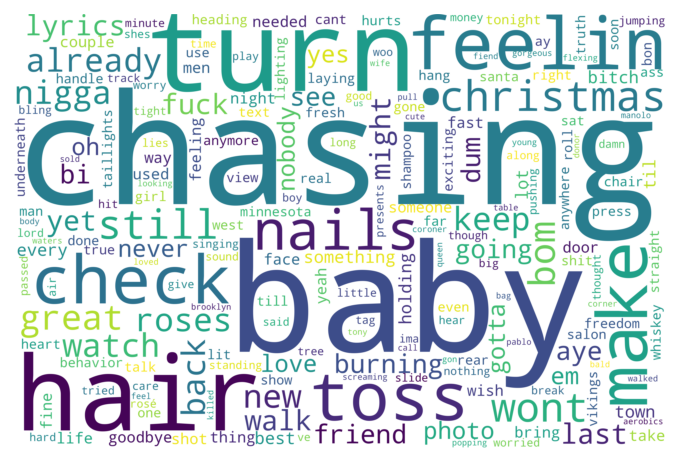

In [58]:
lyrics = ''
for i in range(6000, 6100):
    lyrics = lyrics + data.at[i, 'lyrics'] + ' '

word_cloud9 = WordCloud(
        width=6000,
        height=4000,
        background_color='white', 
        collocations=False,
        stopwords=stop_words
    ).generate(lyrics)

plt.imshow(word_cloud9, interpolation="bilinear")
plt.axis("off")
(-1.5, 200, 100, -2.5)
plt.show()

In 2020 we can see a huge increase in the use of derogatory language. and'Love' is no longer popular. However 'baby' is still a frequent word. Also 'christmas' is popular as well, surprisingly 'hair' is quite popular in song lyrics as well. But if we look closely the use of the words 'nigga', 'bitch', 'money', 'fuck' have started to become popular as well. This is surprising as these words were not seen  before and the shift was more sudden than I imagined. I wonder what the reason for this sudden change is. It could be social media and inernet making deroogatory languages mainstream as there is an exponential increase in internet user between 2020 and 2000.

These wordclouds showed us that love songs are the most popular songs of all time and that there is a big shift in 2020 in terms of popularity using derogatory language. I wonder if we can see the cheange clearer if a sentimental analysis is performed on the dataset.

### 3.2 Sentimental Analysis of Popular Song Lyrics 
A Sentimental Analysis can be helpful in analysing the changes in emotions the lyrics have over time. This could tellus if there are any chhanges and whether there actually is a change in emotional music.  
To do this analysis we can use vader from NLTK library, vader is one of the most popular sentimental analysis tool. We can use vader to calculate the emotions (Negative, Positive, Neutral, Compound). We can then use the averages to compare it against time. So we first calculate the sentiments for each lyrics in our dataset and add it to our data.

In [5]:
sentiAnalyser = SentimentIntensityAnalyzer()

data['Neg_Sentiment'] = 0
data['Neu_Sentiment'] = 0
data['Pos_Sentiment'] = 0
data['Comp_Sentiment'] = 0

for i in range(0, len(data)):
    # Calculate the sentiments for each lyrics in our dataset 
    sen_score = sentiAnalyser.polarity_scores(data['lyrics'][i])
    
    # Adding it to our dataset
    data.loc[i,['Neg_Sentiment']] = sen_score['neg']
    data.loc[i,['Neu_Sentiment']] = sen_score['neu']
    data.loc[i,['Pos_Sentiment']] = sen_score['pos']
    data.loc[i,['Comp_Sentiment']] = sen_score['compound']

We now calculate averages for top 100 of each decade and graph the sentiments change within the lyrics.

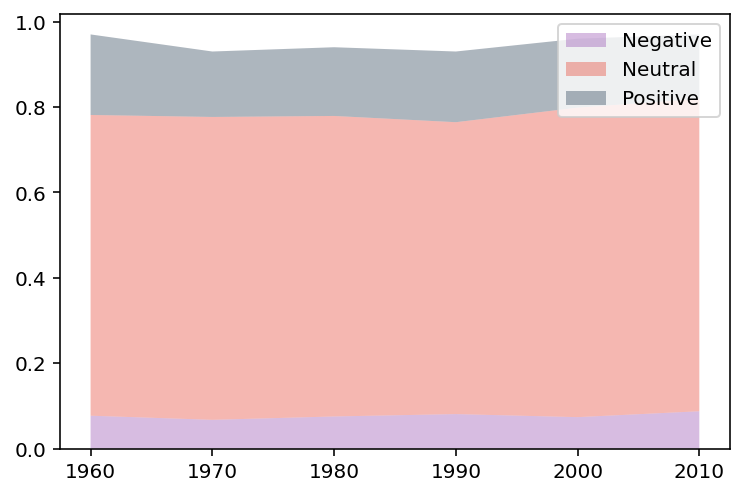

In [11]:
lyrics = ''
decades = [1960, 1970, 1980, 1990, 2000, 2010]
avgNeg = []
avgNeu = []
avgPos = []
avgComp = []

# We now calculate averages for top 100 of each decade
for i in range(0, len(decades)):
    Neg = 0
    Neu = 0
    Pos = 0
    Comp = 0
    for j in range((i*1000) + 0, (i*1000) + 101):
        Neg = Neg + data.at[j, 'Neg_Sentiment']
        Neu = Neu + data.at[j, 'Neu_Sentiment']
        Pos = Pos + data.at[j, 'Pos_Sentiment']
        Comp = Comp + data.at[j, 'Comp_Sentiment']
    avgNeg.append(Neg/100)
    avgNeu.append(Neu/100)
    avgPos.append(Pos/100)
    avgComp.append(Comp/100)

# Area Graph the sentiments
sentiAnalysis = [avgNeg, avgNeu, avgPos]
pallete = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
plt.stackplot(decades, sentiAnalysis, labels=['Negative','Neutral','Positive'], colors=pallete, alpha=0.4 )
plt.legend(loc='upper right')
plt.show()

Let us now focus on the positive and negative emotions as that is the change we are analysing.

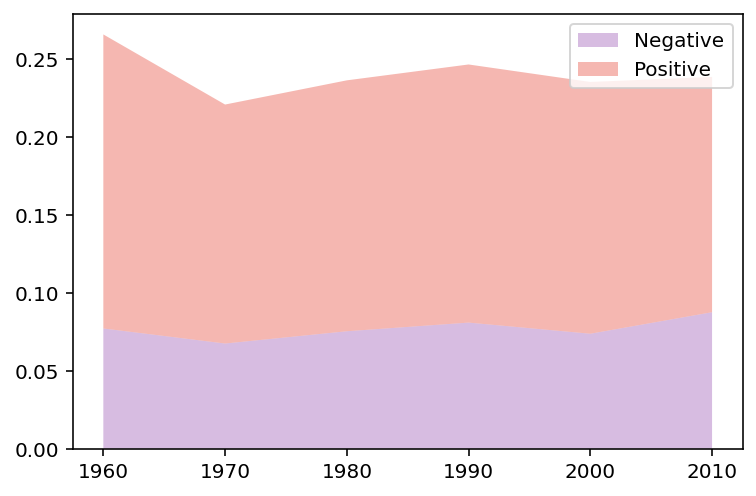

In [13]:
sentiAnalysis = [avgNeg, avgPos]
pallete = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
plt.stackplot(decades, sentiAnalysis, labels=['Negative','Positive'], colors=pallete, alpha=0.4 )
plt.legend(loc='upper right')
plt.show()

We can now see an area graph that compares the negative and positive sentiment of the lyrics. From this graph we can also a slight increase in negativity and decreasee of positive sentiment in between 2000 and 2010. There is also a steep decrease in positivity in between 1960 and 1970.

To get a clearer change we can use a bar chart to show the change even clearer.

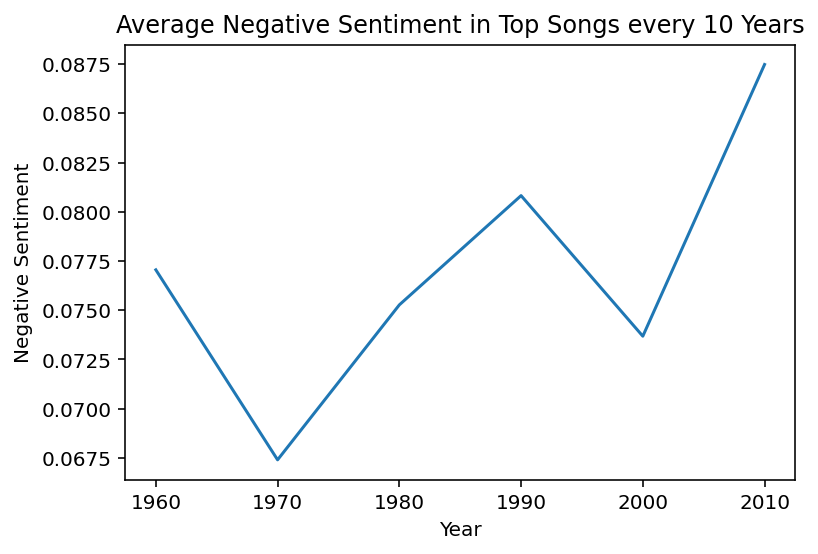

In [22]:
plt.plot(decades,avgNeg)
plt.title('Average Negative Sentiment in Top Songs every 10 Years')
plt.xlabel('Year')
plt.ylabel('Negative Sentiment')
plt.show()

As you can see the negaivity does increase between 2000 and 2010 remains the all time high for negative sentiment in lyrics.

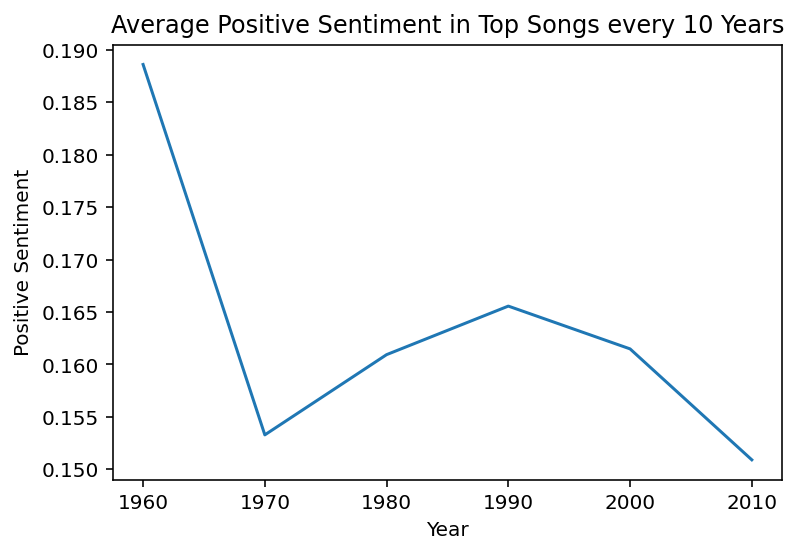

In [34]:
plt.plot(decades,avgPos)
plt.title('Average Positive Sentiment in Top Songs every 10 Years')
plt.xlabel('Year')
plt.ylabel('Positive Sentiment')
plt.show()

We can also see a decrease in positivity in between 1990 and 2010 as well as a signifiicant decrease in positivity between 1960 and 1970.

### 3.3 Average Word Count Analysis
To visuallize the changes in average word count length over a gap of 10 years a line graph can be used to visualize the correlation between average words and time. For this a for loop, loops over the an array which stores years with a ten year interval. For each interval we store the top 100 lyrics of the year and divide it by 100 to get the average word count. 

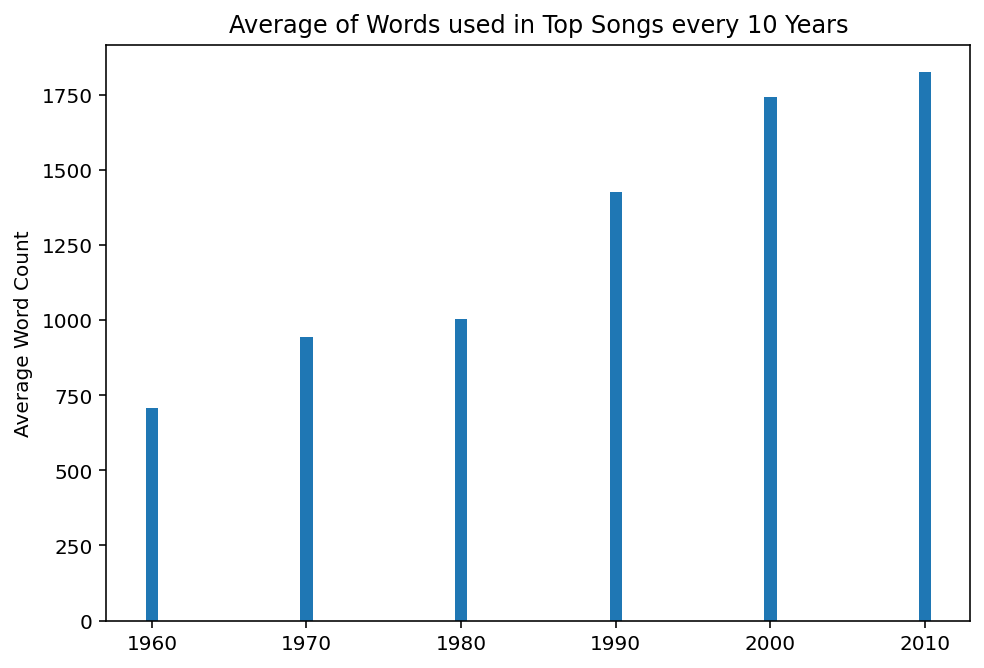

In [33]:
lyrics = ''
decades = [1960, 1970, 1980, 1990, 2000, 2010]
wordAvg = []

for i in range(0, len(decades)):
    lyrics = ''
    for j in range((i*1000) + 0, (i*1000) + 101):
        lyrics = lyrics + data.at[j, 'lyrics'] + ' '
    wordAvg.append(len(lyrics)/100)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average of Words used in Top Songs every 10 Years')
ax.set_ylabel('Average Word Count')
ax.bar(decades,wordAvg)
plt.show()

From this we can see that since 1960 the length of lyrics have been increasing however a exponential increase can be seen 1970 and onwards. Which was surprising, I believe this is a result of a popularization of faster paced music which needs more lyrics like Rap and Pop. The graph seems  to have a steady increas in between 1980 and 2000 where it then slowes down. This was interesting as many say that music today don't have lyrics but from the analysis we can see that in fact its the opposite where lyrics have been getting longer; however their quality is a different question.   

## 4.0 Ethics
The data used for this analysis has been scraped from Wikipedia and Songlyrics.com who owns the licences to these lyrics as the artists own copyrights. Howevver as this analysis has no profit objective and does not harm the artists neighther prevents readers from using Songlyrics.com there should not be no harm in using the data. Even though lyrics are used for the analysis we have created a new form of intellectual property which is different from the scraped lyrics. The data analysis is harmless and cannot produce any dangerous or harmful assumptions as it is simply analysing lyrics that are already popular. However we  were unable to scrape all the lyrics this can result in a potential bias in the analysis of lyrics.   


## 5.0 Summary and Evaluation
In this analysis we have explored the changesin lyrics over time, from the word cloud I discovered a sudden change in the use of deroggaory language in between 2000 and 2010. This was further evident in the sentimental analysis whhich clearly shows the negative sentiment increasing and positive sentiment decreasing in bettween 2000 and 2010. We now know that in fact there is a big shift in usage of deroggatory language in the 2000. It eould be interesting to further explore the reasoning for thae change whether its the internet, economic or political reasoning. Additionaly I explored lyrics length over time where we discovered that lyrics length have been increasing almost linaerly with time. 
This was a very enjyable analysis however I faced issues when choosing datasets as many were not in the correct format and scraping this dataset took much longer than expected. Unfortunatell I could not use any APIs like Genius API which provides lyrics but only allows searching by artist instead of song name. If I had more time I would continue this exploration usiing the  spotify api which even gives you the data of loudness and acoustic information of songs. I believe that could take this exploration to another level however unfortunately a lot of my time was spent on scraping. It would also be interesting to compare this data with external factors like economic or social indicators to find reasons for the change.

## 6.0 References and Resources
### References
- Lizzo Article - https://metro.co.uk/2022/06/14/lizzo-changes-offensive-lyric-in-new-song-grrrls-after-backlash-16822617/
- Lizzo Details - https://www.lizzomusic.com/
- Controversial Lyrics Changes - https://www.billboard.com/lists/artists-who-changed-offensive-song-lyrics/mark-knopfler-money-for-nothing/

### Resources
- Wikipedia Scraping - https://sateesh110.medium.com/how-to-scrape-wikipedia-table-using-python-beautiful-soup-cd0d8ee1a319
- Lyrics Scraping 
    - https://stackoverflow.com/questions/67992715/how-do-i-scrape-lyrics-from-a-list-of-song-lyric-urls,
    - https://stackoverflow.com/questions/70069761/how-to-make-web-scraping-faster
- Try Except - https://www.w3schools.com/python/python_try_except.asp
- Data Cleaning - https://realpython.com/python-data-cleaning-numpy-pandas/
- Visualisations
    - https://www.coursera.org/learn/uol-cm2015-programming-with-data/
    - https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
    - https://www.geeksforgeeks.org/generating-word-cloud-python/
    - https://www.datacamp.com/tutorial/wordcloud-python
    - https://www.projectpro.io/recipes/add-custom-stopwords-and-then-remove-them-from-text